In [ ]:
# ===================================================================
# 共通セットアップセル (ローカル / Colab 共通)
# ===================================================================
import sys
import os
from pathlib import Path

# --- 1. 環境判別 ---
IN_COLAB = False
try:
    # Colab環境でのみインポートが成功する
    from google.colab import drive
    IN_COLAB = True
except ImportError:
    pass # ローカル環境


if IN_COLAB:
    # ==================================
    # Colab 環境でのセットアップ
    # ==================================
    print("環境: Colab を検出。セットアップを開始します。")

    # 1. Google Driveのマウント
    drive.mount('/content/drive')

    # 2. GitHubリポジトリのクローンまたはプル
    repo_path = Path('/content/braidyn-bc')
    if repo_path.exists():
        print("リポジトリを pull します...")
        os.chdir(repo_path)
        !git pull
    else:
        print("リポジトリを clone します...")
        !git clone https://github.com/nyaamikeneko/braidyn-bc.git
        os.chdir(repo_path)

    # 3. 依存ライブラリのインストール
    print("依存ライブラリをインストールします...")
    !pip install -q pynwb git+https://github.com/BraiDyn-BC/bdbc-nwb-explorer.git

    # 4. sys.path の設定
    project_root = repo_path
    if str(project_root) not in sys.path:
        sys.path.append(str(project_root))

    print(f"セットアップ完了。プロジェクトルート: {project_root}")

else:
    # ==================================
    # ローカル (VSCode) 環境でのセットアップ
    # ==================================
    print("環境: ローカル (VSCode) を検出。")

    # 1. sys.path の設定
    current_dir = Path.cwd()
    if current_dir.name == 'notebooks':
        # ノートブックが notebooks/ から実行された場合
        project_root = current_dir.parent
    else:
        # プロジェクトルート (braidyn-bc/) から実行されたと仮定
        project_root = current_dir

    if str(project_root) not in sys.path:
        sys.path.append(str(project_root))

    print(f"プロジェクトルート: {project_root}")

# ===================================================================
# 共通インポート・処理
# (セットアップが完了したため、config.py や src/ が読み込める)
# ===================================================================
print("\n共通モジュールをインポートします...")

import bdbc_nwb_explorer as nwbx
import src.data_loader as dl
import config  # config.py もここで読み込める

print(f"データパス (DATA_NWB_ROOT): {config.DATA_NWB_ROOT}")

In [ ]:
# --- 必要なデータを関数で読み出す ---
SESSION_ID = "VG1GC-105"
NWB_FILENAME = "VG1GC-105_2024-02-02_task-day8.nwb"
TASK_DAY_DIR = "task-day8"

# NWBデータの読み込み
# (dl は共通セルでインポート済み)
session = dl.load_nwb_session(SESSION_ID, NWB_FILENAME)

# CSVデータの読み込み
trials = dl.load_trials_csv(SESSION_ID, TASK_DAY_DIR)

# これ以降、 session や trials を使った分析処理を記述...
if trials is not None:
    print(trials.head())

In [ ]:
# VSCodeで .py ファイルをインポートするための設定
# (src/ がインポートリストに含まれるようにする)
import sys
from pathlib import Path
import os

# ノートブックの実行場所がプロジェクトルートか notebooks/ かを判定
current_dir = Path.cwd()
if current_dir.name == 'notebooks':
    # もしカレントディレクトリが notebooks/ なら、親（プロジェクトルート）をパスに追加
    project_root = current_dir.parent
    if str(project_root) not in sys.path:
        sys.path.append(str(project_root))
elif 'src' not in sys.path:
    # プロジェクトルートにいると仮定し、srcをパスに追加
    if str(current_dir / 'src') not in sys.path:
         sys.path.append(str(current_dir / 'src'))
    if str(current_dir) not in sys.path:
         sys.path.append(str(current_dir))

# --- ここからが本番 ---
# モジュール化したデータローダーをインポート
try:
    import src.data_loader as dl
except ModuleNotFoundError:
    print("エラー: src.data_loader が見つかりません。")
    print("VSCodeの実行ディレクトリがプロジェクトルートになっているか確認してください。")

# --- 必要なデータを関数で読み出す ---
SESSION_ID = "VG1GC-105"
NWB_FILENAME = "VG1GC-105_2024-02-02_task-day8.nwb"
TASK_DAY_DIR = "task-day8"

# NWBデータの読み込み
# session = dl.load_nwb_session(SESSION_ID, NWB_FILENAME)

# CSVデータの読み込み
trials = dl.load_trials_csv(SESSION_ID, TASK_DAY_DIR)

# これ以降、 session や trials を使った分析処理を記述...
if trials is not None:
    print(trials.head())

In [ ]:
#0530
import pandas as pd
from pathlib import Path

# ---------- ① データ読み込み ----------
CSV_PATH = Path('/content/drive/MyDrive/hackathon_data/VG1GC-105/task-day7/trials_L1L2.csv')
trials   = pd.read_csv(CSV_PATH)

# ---------- ② 音なし & pull  -----------------------------------------
mask_nosound_pull = (
    (trials.state_task == 0) &            # 音なし
    (trials.state_lever == 1) &           # レバーを押した記録
          # pull_onset が入っている (= 確実に押した)
    (trials.diff_value > 0.4)             # 閾値フィルタ
)
nosound_pull = trials.loc[mask_nosound_pull].copy()
nosound_pull['event_t'] = nosound_pull['t'] - nosound_pull['diff_value']   # lever_time_nocue

# ---------- ③ 音あり & pull  -----------------------------------------
mask_sound_pull = (    # 音あり
           # 押した
    (trials.first_diff   > 1.0) &         # 反応時間以外のフィルタ
    (trials.reaction_time.between(0.091, 0.361))
)
sound_pull = trials.loc[mask_sound_pull].copy()
sound_pull['event_t'] = sound_pull['pull_onset']          # レバーを引いた瞬間

# ---------- ④ 音あり & nopull  ---------------------------------------
mask_sound_nopull = (         # 音あり
           # レバーを引いていない
    (trials.trial_outcome == 'failure')   # 明示的に失敗扱い
)
sound_nopull = trials.loc[mask_sound_nopull].copy()

# 　ポイント時刻：音が鳴った瞬間
for col in ('sound_onset', 'start_time', 't'):            # 列の優先順
    if col in sound_nopull.columns:
        sound_nopull['event_t'] = sound_nopull[col]
        break
else:
    raise ValueError("sound_onset / start_time / t のいずれの列も見つかりません")

# ---------- ⑤ デバッグ用に件数を確認 ----------
print(f"音なし pull       : {len(nosound_pull):3d} trials")
print(f"音あり pull        : {len(sound_pull):3d} trials")
print(f"音あり nopull      : {len(sound_nopull):3d} trials")

# ---------- ⑥ 目的の Series (時刻) を用意 -----------------------------
sound_onsets    = sound_pull['event_t'].reset_index(drop=True)     # 音あり pull
no_sound_onsets = nosound_pull['event_t'].reset_index(drop=True)   # 音なし pull
sound_nopull_on = sound_nopull['event_t'].reset_index(drop=True)   # 音あり nopull

# 使いたいならまとめて dict に
onset_dict = {
    'sound_pull'   : sound_onsets,
    'nosound_pull' : no_sound_onsets,
    'sound_nopull' : sound_nopull_on,
}


音なし pull       : 283 trials
音あり pull        :  51 trials
音あり nopull      :  26 trials


音なし pull       : 283
音あり pull        :  51
音あり nopull      :  26


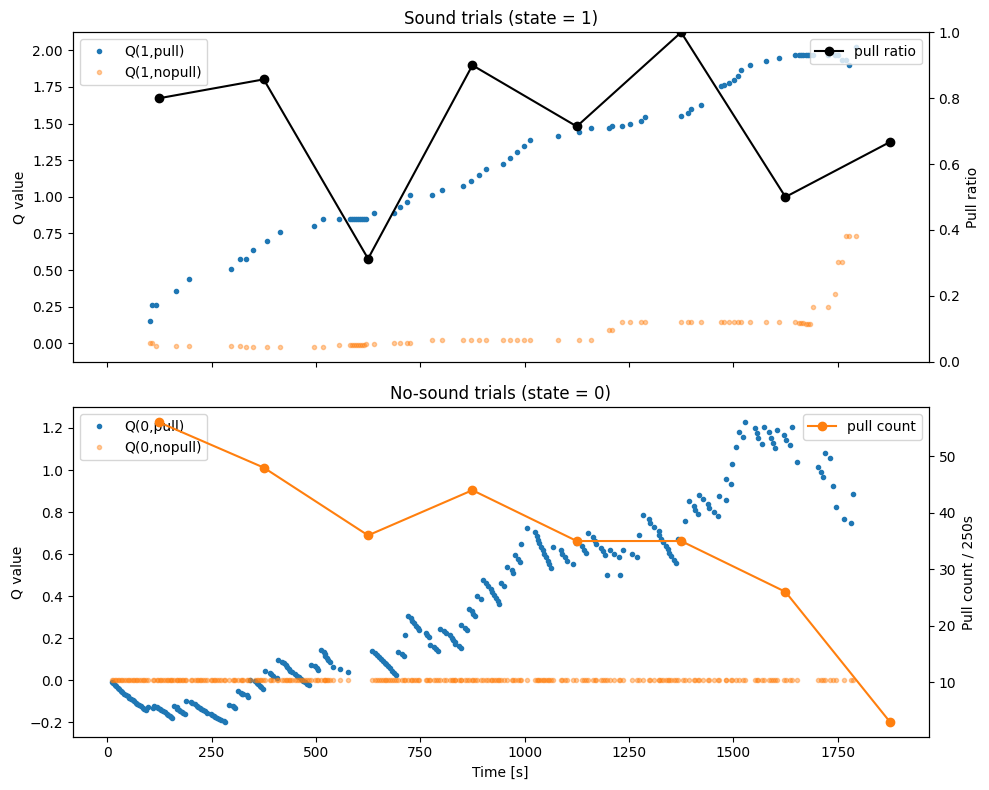

In [ ]:
"""
====================================================================
  OFF-POLICY SARSA でマウスの “内部 Q 値” を推定する最小構成（改訂版）
  ---------------------------------------------------------------
  * 3 カテゴリの試行を重複なく抽出
      1. 音なし & pull
      2. 音あり & pull
      3. 音あり & nopull（pull_onset==NaN）
  * イベント時刻
      ─ 音なし & pull        : t − diff_value  (= lever_time_nocue)
      ─ 音あり & pull        : pull_onset
      ─ 音あり & nopull      : 音開始時刻（sound_onset → start_time → t の優先順）
  * TD 更新は OFF-POLICY SARSA
====================================================================
"""

# ----------------------------  SET-UP  -----------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# ---------- ❶ パラメータ ----------
CSV_PATH      = Path('/content/drive/MyDrive/hackathon_data/VG1GC-105/task-day7/trials_L1L2.csv')
THRESH_DIFF   = 0.4                 # 音なし判定用 diff_value 閾値
RT_LOWER, RT_UPPER = 0.091, 0.361   # 音あり pull の反応時間フィルタ
FIRST_DIFF_MIN     = 1.0            # 反応時間フィルタ 2
ALPHA   = 0.15                      # 学習率
GAMMA   = 0.90                      # 割引率 (0.0 なら逐次平均)
PENALTY = 0.05                      # 音なし pull 罰則
BIN_W   = 250                       # pull 率集計ビン [s]

# ---------------------------- ❷ データ -----------------------------
trials = pd.read_csv(CSV_PATH)

# ---------------------------- ❸ 試行抽出 ---------------------------
## --- 3.1  音なし & pull  ------------------------------------------
mask_nosound_pull = (
    (trials.state_task == 0) &          # 音なし
    (trials.state_lever == 1) &         # レバー押しフラグ
       # pull_onset が存在
    (trials.diff_value > THRESH_DIFF)   # diff_value 閾値
)
nosound_pull = trials.loc[mask_nosound_pull].copy()
nosound_pull['event_t'] = nosound_pull['t'] - nosound_pull['diff_value']

## --- 3.2  音あり & pull  ------------------------------------------
mask_sound_pull = (
       # 音あり
        # レバーを押した
    (trials.first_diff > FIRST_DIFF_MIN) &
    (trials.reaction_time.between(RT_LOWER, RT_UPPER))
)
sound_pull = trials.loc[mask_sound_pull].copy()
sound_pull['event_t'] = sound_pull['pull_onset']

## --- 3.3  音あり & nopull -----------------------------------------
mask_sound_nopull = (
         # 音あり
    trials.pull_onset.isna() &          # レバーを押していない
    (trials.trial_outcome == 'failure') # 明示的失敗
)
sound_nopull = trials.loc[mask_sound_nopull].copy()

for col in ('sound_onset', 'start_time', 't'):      # 音開始時刻の優先順
    if col in sound_nopull.columns:
        sound_nopull['event_t'] = sound_nopull[col]
        break
else:
    raise ValueError('sound_onset / start_time / t が見つかりません')

# ------- ❸-A デバッグ：件数確認 -------
print(f"音なし pull       : {len(nosound_pull):3d}")
print(f"音あり pull        : {len(sound_pull):3d}")
print(f"音あり nopull      : {len(sound_nopull):3d}")

# ---------------------------- ❹ イベント表 --------------------------
def build_events(df, state_val, action_val, reward_val):
    return pd.DataFrame({
        't'     : df['event_t'],
        'state' : state_val,       # 0: no-sound, 1: sound
        'action': action_val,      # 0: nopull,  1: pull
        'reward': reward_val
    })

events = pd.concat([
    build_events(sound_pull,     1, 1,  1),           # 正報酬
    build_events(sound_nopull,   1, 0,  0),           # 無報酬
    build_events(nosound_pull,   0, 1, -PENALTY)      # 罰則
]).sort_values('t').reset_index(drop=True)

# pull 率／pull 回数 集計用ビン
events['bin'] = (events.t // BIN_W) * BIN_W + BIN_W/2

# ---------------------------- ❺ SARSA 更新 --------------------------
Q = np.zeros((2, 2))          # Q[state, action]
log = []

for i in range(len(events) - 1):
    s, a, r = int(events.at[i,   'state']), int(events.at[i,   'action']), events.at[i,   'reward']
    sp, ap  = int(events.at[i+1, 'state']), int(events.at[i+1, 'action'])
    td      = r + GAMMA * Q[sp, ap] - Q[s, a]
    Q[s, a] = Q[s, a] + ALPHA * td
    # ログ：pull/nopull それぞれの Q
    log.append([events.at[i, 't'], s, a, Q[s, 1], Q[s, 0]])

df_log = pd.DataFrame(log, columns=['t', 'state', 'action', 'Q_pull', 'Q_nop'])

# ---------------------------- ❻ 指標 -------------------------------
pull_ratio_sound = (
    events[events.state == 1]
    .groupby('bin')['action'].mean()
)
pull_count_nosound = (
    events[(events.state == 0) & (events.action == 1)]
    .groupby('bin').size()
)



# ---------- 可視化 ----------
fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# 音あり
mask_sound_log = df_log.state == 1
ax = axes[0]
ax.plot(df_log.loc[mask_sound_log, 't'], df_log.loc[mask_sound_log, 'Q_pull'], '.', label='Q(1,pull)')
ax.plot(df_log.loc[mask_sound_log, 't'], df_log.loc[mask_sound_log, 'Q_nop'], '.', alpha=0.4, label='Q(1,nopull)')
ax.set_ylabel('Q value')
ax.set_title('Sound trials (state = 1)')
ax.legend(loc='upper left')

ax2 = ax.twinx()
ax2.plot(pull_ratio_sound.index, pull_ratio_sound.values, 'k-o', label='pull ratio')
ax2.set_ylim(0, 1)
ax2.set_ylabel('Pull ratio')
ax2.legend(loc='upper right')

# 音なし
mask_nosound_log = df_log.state == 0
ax = axes[1]
ax.plot(df_log.loc[mask_nosound_log, 't'], df_log.loc[mask_nosound_log, 'Q_pull'], '.', label='Q(0,pull)')
ax.plot(df_log.loc[mask_nosound_log, 't'], df_log.loc[mask_nosound_log, 'Q_nop'], '.', alpha=0.4, label='Q(0,nopull)')
ax.set_ylabel('Q value')
ax.set_title('No-sound trials (state = 0)')
ax.legend(loc='upper left')

ax2 = ax.twinx()
ax2.plot(pull_count_nosound.index, pull_count_nosound.values, 'C1-o', label='pull count')
ax2.set_ylabel(f'Pull count / {BIN_W}s')
ax2.legend(loc='upper right')

axes[1].set_xlabel('Time [s]')
plt.tight_layout()
plt.show()


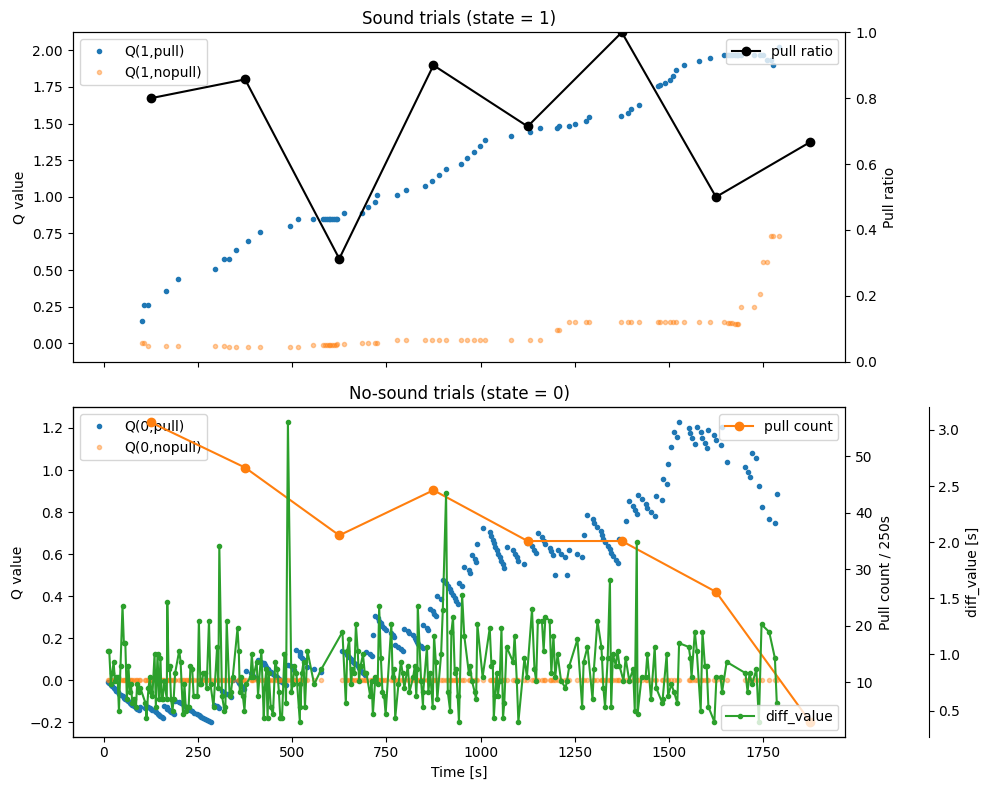

In [ ]:
# ---------- 可視化（Diff_value も追加） ----------
fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# --- ① 音ありトライアルの Q と pull ratio ---
mask_sound_log = df_log.state == 1
ax = axes[0]
ax.plot(df_log.loc[mask_sound_log, 't'],
        df_log.loc[mask_sound_log, 'Q_pull'],   '.', label='Q(1,pull)')
ax.plot(df_log.loc[mask_sound_log, 't'],
        df_log.loc[mask_sound_log, 'Q_nop'],    '.', alpha=0.4, label='Q(1,nopull)')
ax.set_ylabel('Q value')
ax.set_title('Sound trials (state = 1)')
ax.legend(loc='upper left')

ax2 = ax.twinx()
ax2.plot(pull_ratio_sound.index,
         pull_ratio_sound.values,            'k-o', label='pull ratio')
ax2.set_ylim(0, 1)
ax2.set_ylabel('Pull ratio')
ax2.legend(loc='upper right')


# --- ② 音なしトライアルの Q, pull count, diff_value 推移 ---
mask_nosound_log = df_log.state == 0
ax = axes[1]
# Q values
ax.plot(df_log.loc[mask_nosound_log, 't'],
        df_log.loc[mask_nosound_log, 'Q_pull'],   '.', label='Q(0,pull)')
ax.plot(df_log.loc[mask_nosound_log, 't'],
        df_log.loc[mask_nosound_log, 'Q_nop'],    '.', alpha=0.4, label='Q(0,nopull)')
ax.set_ylabel('Q value')
ax.set_title('No-sound trials (state = 0)')
ax.legend(loc='upper left')

# pull count
ax2 = ax.twinx()
ax2.plot(pull_count_nosound.index,
         pull_count_nosound.values,         'C1-o', label='pull count')
ax2.set_ylabel(f'Pull count / {BIN_W}s')
ax2.legend(loc='upper right')

# diff_value の推移
ax3 = ax.twinx()
ax3.spines['right'].set_position(('outward', 60))   # 第3軸を右にオフセット
ax3.plot(nosound_pull['event_t'],
         nosound_pull['diff_value'],          'C2.-', label='diff_value')
ax3.set_ylabel('diff_value [s]')
ax3.legend(loc='lower right')

axes[1].set_xlabel('Time [s]')
plt.tight_layout()
plt.show()


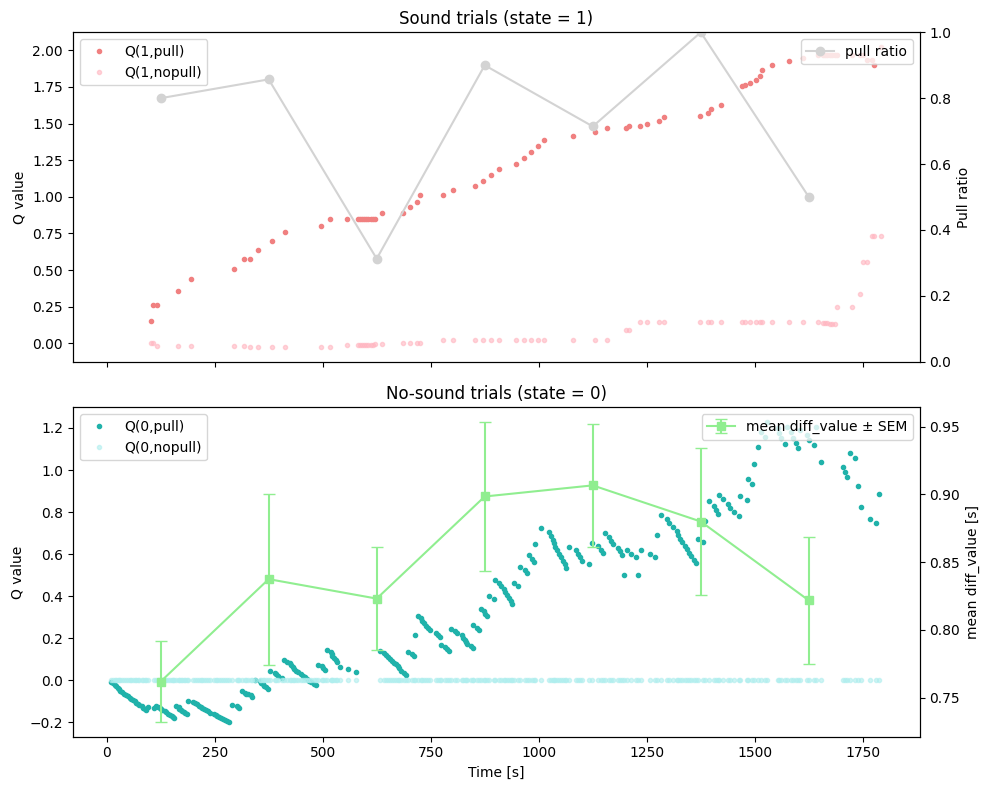

In [ ]:

# ---------- 可視化（1750秒以降除外＆パステルカラー） ----------
# 1750秒未満のビンに限定
mask_bins = diff_mean.index < 1750
diff_mean = diff_mean[mask_bins]; diff_sem = diff_sem[mask_bins]
pull_ratio_sound = pull_ratio_sound[pull_ratio_sound.index < 1750]

fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# 音あり：Q & pull ratio
mask_sound = df_log.state==1
ax = axes[0]
ax.plot(df_log.loc[mask_sound,'t'], df_log.loc[mask_sound,'Q_pull'], '.', color='lightcoral', label='Q(1,pull)')
ax.plot(df_log.loc[mask_sound,'t'], df_log.loc[mask_sound,'Q_nop'], '.', alpha=0.6, color='lightpink', label='Q(1,nopull)')
ax.set_ylabel('Q value'); ax.set_title('Sound trials (state = 1)'); ax.legend(loc='upper left')
ax2 = ax.twinx()
ax2.plot(pull_ratio_sound.index, pull_ratio_sound.values, 'o-', color='lightgray', label='pull ratio')
ax2.set_ylim(0,1); ax2.set_ylabel('Pull ratio'); ax2.legend(loc='upper right')

# 音なし：Q & diff_value ± SEM
mask_nosound = df_log.state==0
ax = axes[1]
ax.plot(df_log.loc[mask_nosound,'t'], df_log.loc[mask_nosound,'Q_pull'], '.', color='lightseagreen', label='Q(0,pull)')
ax.plot(df_log.loc[mask_nosound,'t'], df_log.loc[mask_nosound,'Q_nop'], '.', alpha=0.6, color='paleturquoise', label='Q(0,nopull)')
ax.set_ylabel('Q value'); ax.set_title('No-sound trials (state = 0)'); ax.legend(loc='upper left')
ax2 = ax.twinx()
ax2.errorbar(diff_mean.index, diff_mean.values, yerr=diff_sem.values,
             fmt='s-', capsize=4, color='lightgreen', label='mean diff_value ± SEM')
ax2.set_ylabel('mean diff_value [s]'); ax2.legend(loc='upper right')

axes[1].set_xlabel('Time [s]')
plt.tight_layout()
plt.show()

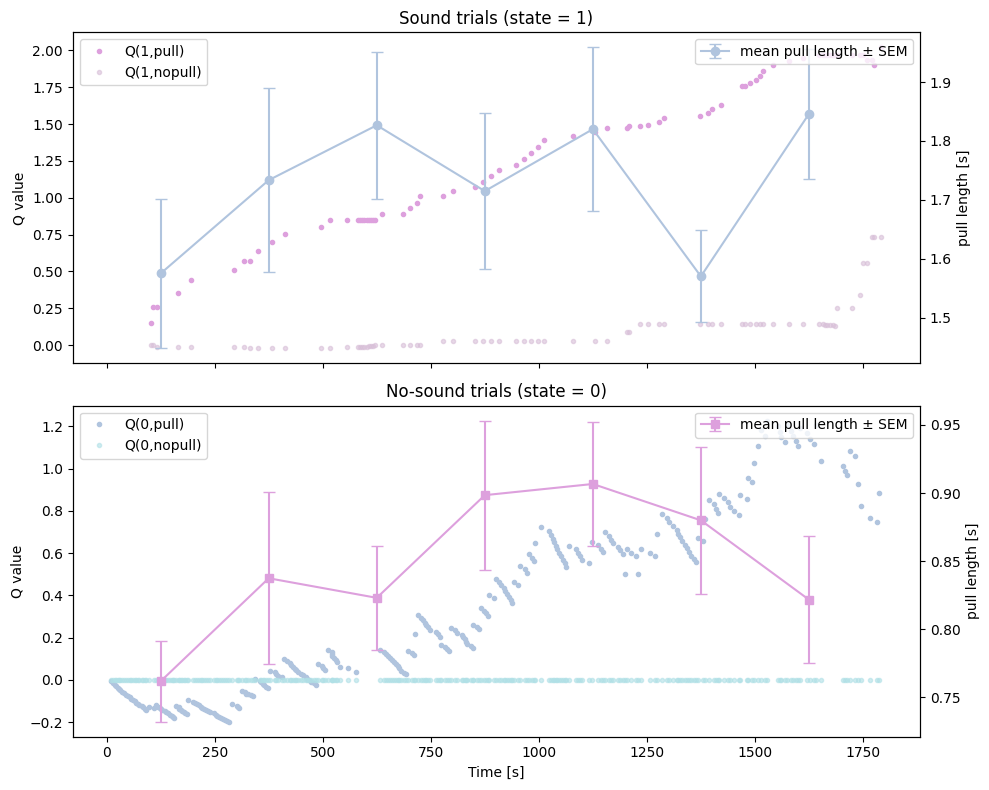

In [ ]:
# ===============================================================
# ❶ 250 s ビン平均 & SEM の準備
# ---------------------------------------------------------------
BIN_W = 250

# ―― 音あり試行（state = 1）first_diff ――
sound_pull['bin'] = (sound_pull['event_t'] // BIN_W) * BIN_W + BIN_W/2
fd_mean = sound_pull.groupby('bin')['first_diff'].mean()
fd_sem  = sound_pull.groupby('bin')['first_diff'].sem()

# ―― 音なし試行（state = 0）diff_value ――
nosound_pull['bin'] = (nosound_pull['event_t'] // BIN_W) * BIN_W + BIN_W/2
dv_mean = nosound_pull.groupby('bin')['diff_value'].mean()
dv_sem  = nosound_pull.groupby('bin')['diff_value'].sem()

# 1750 s 以降は描かない
fd_sel = fd_mean.index < 1750
dv_sel = dv_mean.index < 1750
fd_mean, fd_sem = fd_mean[fd_sel], fd_sem[fd_sel]
dv_mean, dv_sem = dv_mean[dv_sel], dv_sem[dv_sel]

# ===============================================================
# ❷ 可視化（パステル紫系 & 水色系、pull_rate は表示しない）
# ---------------------------------------------------------------
fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# ---------- A. 音あり (state = 1) ----------
mask_sound = df_log.state == 1
ax = axes[0]

# Q 値
ax.plot(df_log.loc[mask_sound,'t'],
        df_log.loc[mask_sound,'Q_pull'], '.', color='plum', label='Q(1,pull)')
ax.plot(df_log.loc[mask_sound,'t'],
        df_log.loc[mask_sound,'Q_nop'],  '.', color='thistle', alpha=0.6, label='Q(1,nopull)')

# first_diff ± SEM（第 2 軸）
ax2 = ax.twinx()
ax2.errorbar(fd_mean.index, fd_mean.values, yerr=fd_sem.values,
             fmt='o-', capsize=4, color='lightsteelblue',
             label='mean pull length ± SEM')

# 軸ラベル等
ax.set_ylabel('Q value')
ax.set_title('Sound trials (state = 1)')
ax.legend(loc='upper left')
ax2.set_ylabel('pull length [s]')
ax2.legend(loc='upper right')

# ---------- B. 音なし (state = 0) ----------
mask_nosound = df_log.state == 0
ax = axes[1]

# Q 値
ax.plot(df_log.loc[mask_nosound,'t'],
        df_log.loc[mask_nosound,'Q_pull'], '.', color='lightsteelblue', label='Q(0,pull)')
ax.plot(df_log.loc[mask_nosound,'t'],
        df_log.loc[mask_nosound,'Q_nop'],  '.', color='powderblue',   alpha=0.6, label='Q(0,nopull)')

# diff_value ± SEM（第 2 軸）
ax2 = ax.twinx()
ax2.errorbar(dv_mean.index, dv_mean.values, yerr=dv_sem.values,
             fmt='s-', capsize=4, color='plum',
             label='mean pull length ± SEM')

# 軸ラベル等
ax.set_ylabel('Q value')
ax.set_title('No-sound trials (state = 0)')
ax.legend(loc='upper left')
ax2.set_ylabel('pull length [s]')
ax2.legend(loc='upper right')

axes[1].set_xlabel('Time [s]')
plt.tight_layout()
plt.show()


In [ ]:
# 相関をみたい！！
BIN_W = 250

# ❷ df_log にビン列を追加
df_log['bin'] = (df_log['t'] // BIN_W) * BIN_W + BIN_W/2

# ❸ 音ありトライアルの Q_pull のビン平均
q_pull_mean = (
    df_log[df_log.state == 1]
    .groupby('bin')['Q_pull']
    .mean()
)

# ❹ sound_pull で作成済みの first_diff ビン平均 (fd_mean) を再利用
#     — もし前のセルで fd_mean を作っていなければ、同じビン振りをして作成してください
#     例：
# sound_pull['bin'] = (sound_pull['event_t'] // BIN_W) * BIN_W + BIN_W/2
# fd_mean = sound_pull.groupby('bin')['first_diff'].mean()

# ❺ 相関用データフレームを結合
corr_df = pd.concat([q_pull_mean, fd_mean], axis=1, join='inner')
corr_df.columns = ['Q_pull', 'first_diff']

# ❻ ピアソン / スピアマン相関を計算
from scipy.stats import pearsonr, spearmanr

pear_r,  pear_p  = pearsonr (corr_df['Q_pull'], corr_df['first_diff'])
spear_r, spear_p = spearmanr(corr_df['Q_pull'], corr_df['first_diff'])

print(f"Pearson  r = {pear_r:.3f},  p = {pear_p:.3g}")
print(f"Spearman ρ = {spear_r:.3f},  p = {spear_p:.3g}")


Pearson  r = 0.368,  p = 0.416
Spearman ρ = 0.286,  p = 0.535


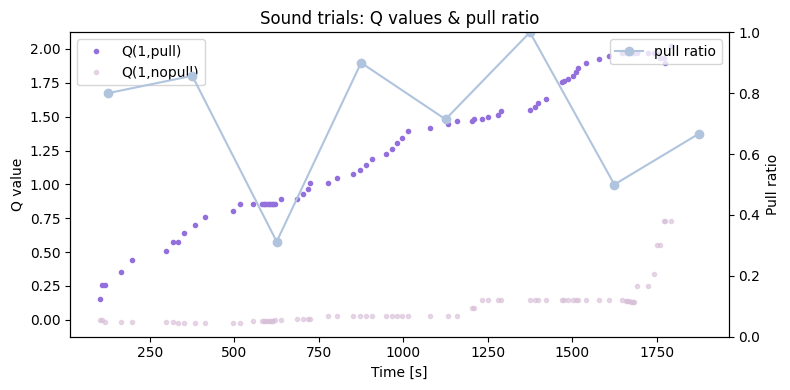

In [ ]:
# ========= pull ratio = 音あり pull ／(音あり pull + 音あり nopull) =========
# 前提: events  (columns: t, state, action, reward, bin) と df_log が既に存在

# --- ①  ビンごとに pull と nopull の回数を数える --------------------------
sound_counts = (
    events[events.state == 1]          # 音あり試行のみ
          .groupby(['bin', 'action'])  # action: 1=pull, 0=nopull
          .size()
          .unstack(fill_value=0)       # 列 0,1 に分ける
)
# 列が存在しない場合に備えて 0 を補完
for col in [0, 1]:
    if col not in sound_counts.columns:
        sound_counts[col] = 0

pull_ratio = sound_counts[1] / (sound_counts[1] + sound_counts[0])

# --- ②  グラフ -----------------------------------------------------------
fig, ax = plt.subplots(figsize=(8, 4))

# Q(1,pull) と Q(1,nopull)
mask_sound = df_log.state == 1
ax.plot(df_log.loc[mask_sound, 't'],
        df_log.loc[mask_sound, 'Q_pull'],
        '.', color='mediumpurple', label='Q(1,pull)')
ax.plot(df_log.loc[mask_sound, 't'],
        df_log.loc[mask_sound, 'Q_nop'],
        '.', alpha=0.6, color='thistle', label='Q(1,nopull)')
ax.set_ylabel('Q value')
ax.set_title('Sound trials: Q values & pull ratio')
ax.legend(loc='upper left')

# pull ratio を第 2 軸に
ax2 = ax.twinx()
ax2.plot(pull_ratio.index, pull_ratio.values,
         'o-', color='lightsteelblue', label='pull ratio')
ax2.set_ylim(0, 1)
ax2.set_ylabel('Pull ratio')
ax2.legend(loc='upper right')

ax.set_xlabel('Time [s]')
plt.tight_layout()
plt.show()

